# Song Recommendation Collaborative Filtering System Trained on Million Song Dataset

Full Name: Yining Yuan
Student ID: 904043914

In this jupyter notebook, I will be training 2 SVD model for collaborative filtering on Million Song Dataset, and compared result for both model's prediction on top 1 and top 5 hit rate. My report is at the end of the file.

In [1]:
import pandas as pd
# from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from surprise import SVD
import seaborn as sns
import numpy as np
import time

In [2]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [3]:
import sys
print(sys.executable)


/mnt/c/Users/17343/Desktop/Song_recommendation/env/bin/python3


## Extract Data
in this section, I extract raw data from datasets downloaded from Million Song Dataset website(http://millionsongdataset.com/). I downloaded: 
1. train_triplets.txt, a dataset containing user preference information, including user_id, song_id, and play_count
2. track_metadata.db, SQLite database containing most metadata about each track

I will be using the play_count attribute in train_triplet dataset as a implicit rating, and the metadata is only used for me to better learn about the data set as a whole.

In [4]:
# Load the dataset
data_df = pd.read_csv('train_triplets.txt', sep='\t', names=['user_id', 'song_id', 'play_count']).head(10000000)

# Number of unique users
num_users = data_df['user_id'].nunique()
print(f"Number of Users: {num_users}")

# Number of unique songs (items)
num_items = data_df['song_id'].nunique()
print(f"Number of Items (Songs): {num_items}")

# Number of ratings (play counts)
num_ratings = len(data_df)
print(f"Number of Ratings (Play Counts): {num_ratings}")

Number of Users: 209542
Number of Items (Songs): 307782
Number of Ratings (Play Counts): 10000000


In [5]:
data_df.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [6]:
import sqlite3
import pandas as pd


# Connect to the track_metadata.db SQLite database
conn = sqlite3.connect('track_metadata.db')

# Extract the song IDs from the data_df to use in the SQL query
song_ids = tuple(data_df['song_id'].unique())

# SQL query to fetch song details for the given song IDs
query = f"""
SELECT song_id, title, artist_name, release, year
FROM songs
WHERE song_id IN {song_ids};
"""

# Execute the query and load the results into a pandas DataFrame
song_metadata_df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

In [7]:
song_metadata_df.head()

,song_id,title,artist_name,release,year
0,SOBNYVR12A8C13558C,Si Vos Querés,Yerba Brava,De Culo,2003
1,SOYGNWH12AB018191E,L'antarctique,3 Gars Su'l Sofa,Des cobras des tarentules,2007
2,SOGPCJI12A8C13CCA0,N Gana,Waldemar Bastos,Afropea 3 - Telling Stories To The Sea,0
3,SOSDCFG12AB0184647,006,Lena Philipsson,Lena 20 År,1998
4,SOKOVRQ12A8C142811,Ethos of Coercion,Dying Fetus,Descend Into Depravity,2009


In [8]:
merged_df = pd.merge(data_df, song_metadata_df, on='song_id', how='left')

In [9]:
merged_df.head()

,user_id,song_id,play_count,title,artist_name,release,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,Thicker Than Water,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,Billy Preston,To Die For,1974
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Flamenco Para Niños,1976
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,Under Cold Blue Stars,Josh Rouse,Under Cold Blue Stars,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,Riot Radio (Soundtrack Version),The Dead 60s,Nick & Norah's Infinite Playlist - Original Mo...,0


## Data Preprocessing

In this part, I will do analysis on how many songs does users normally listen to, and how many listening count does a song usually gets. By filtering out the small values, I could improve the train dataset quality.

In [10]:
data_df = merged_df.copy()

#### Analyzing dataset: look at how many songs does a user listen to

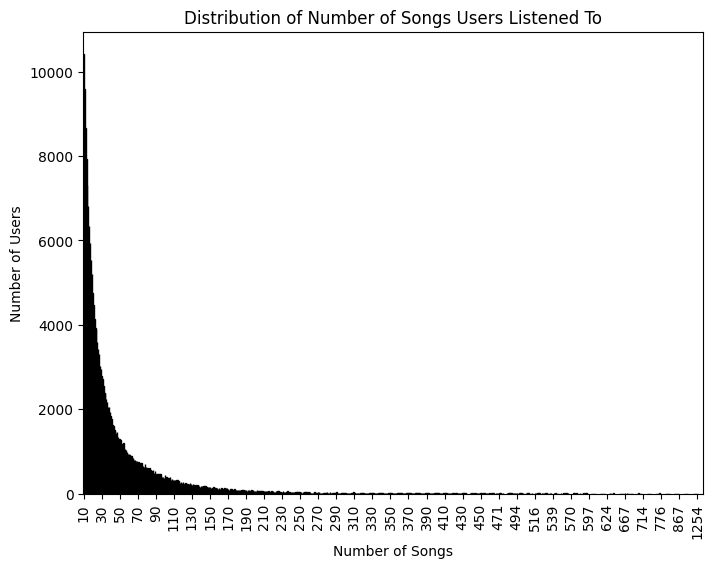

In [11]:
# Count how many unique songs each user has listened to
user_song_counts = data_df.groupby('user_id')['song_id'].nunique()

# Plot a bar chart of the number of songs listened to by each user
ax = user_song_counts.value_counts().sort_index().plot(kind='bar', figsize=(8, 6), edgecolor='black')

# Set x-axis labels to display only every nth label
step_size = 20  # Change this value to control the frequency of x-tick labels
ax.set_xticks(range(0, len(user_song_counts.value_counts()), step_size))
ax.set_xticklabels(user_song_counts.value_counts().sort_index().index[::step_size])

# Add labels and title
plt.title('Distribution of Number of Songs Users Listened To')
plt.xlabel('Number of Songs')
plt.ylabel('Number of Users')

# Show the plot
plt.show()

from the plot, we can see that most people listen to 1-150 songs. I will filter out users who listens to < 20 songs since their data would potentially be misleading to the model

In [12]:
len(data_df)

10266784

In [13]:
# Step 1: Count how many unique songs each user has listened to
user_song_counts = data_df.groupby('user_id')['song_id'].nunique()

# Step 2: Filter out users who listened to fewer than 10 songs
users_with_20_or_more_songs = user_song_counts[user_song_counts >= 20].index

# Step 3: Filter the original data_df to keep rows where the user_id is in users_with_10_or_more_songs
filtered_data_df = data_df[data_df['user_id'].isin(users_with_20_or_more_songs)]


In [14]:
len(filtered_data_df)

9215728

#### Analyzing dataset: look at how many play count each song has

In [15]:
# Mean and median play counts
mean_play_count = filtered_data_df['play_count'].mean()
median_play_count = filtered_data_df['play_count'].median()
print(f"Mean Play Count: {mean_play_count:.2f}")
print(f"Median Play Count: {median_play_count}")

Mean Play Count: 2.83
Median Play Count: 1.0


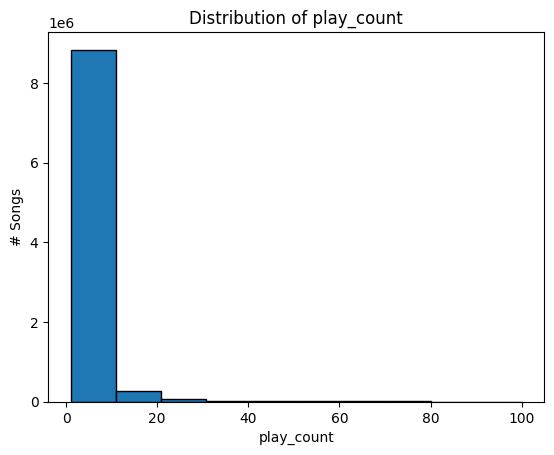

In [16]:
# Sample data: a list of numbers
data = filtered_data_df['play_count']

# Create a histogram with a specific range
plt.hist(data, bins=10, range=(1, 100), edgecolor='black')
# Add title and labels
plt.title("Distribution of play_count")
plt.xlabel("play_count")
plt.ylabel("# Songs")

# Show the plot
plt.show()

we should filter out songs with too litte play_count, becuase it may not have enough use data to be accurately representated in the model. In thsi case, I choose to filter out songs with < 100 play count

In [17]:
len(filtered_data_df)

9215728

In [18]:
# Count how many times each song has been listened to
song_listening_counts = filtered_data_df.groupby('song_id')['user_id'].nunique()

# Filter out songs with fewer than a minimum threshold of interactions (>= 100)
songs_with_enough_interactions = song_listening_counts[song_listening_counts >= 100].index

# Filter the original data_df to keep only rows where the song has enough interactions
filtered_data_df2 = filtered_data_df[filtered_data_df['song_id'].isin(songs_with_enough_interactions)]


In [19]:
len(filtered_data_df2)

6047430

## Rate Scale Conversion

since the dataset only contains play count as implicit rating, I looked at data distribution, and tried using a custom binning technique to convert listening counts to rating.

In [20]:
# Checking the maximum rating
max_rating = filtered_data_df2['play_count'].max()
print(f"Maximum Listening Count: {max_rating}")

# Checking the minimum rating
min_rating = filtered_data_df2['play_count'].min()
print(f"Minimum Listening Count: {min_rating}")

# Checking the mean rating
mean_rating = filtered_data_df2['play_count'].mean()
print(f"Mean Listening Count: {mean_rating:.2f}")

# Checking different percentiles (e.g., 25th, 50th, 75th, 90th)
percentiles = [0.25, 0.50, 0.75, 0.90]
percentile_values = filtered_data_df2['play_count'].quantile(percentiles)

# Print the percentile values
for p, value in zip(percentiles, percentile_values):
    print(f"{int(p*100)}th Percentile: {value}")


Maximum Listening Count: 2213
Minimum Listening Count: 1
Mean Listening Count: 2.93
25th Percentile: 1.0
50th Percentile: 1.0
75th Percentile: 3.0
90th Percentile: 6.0


#### custom binning

In [21]:
binning_data2 = filtered_data_df2.copy()
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

In [22]:
binning_data2['play_count'] = pd.cut(binning_data2['play_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

listen_counts_custom = pd.DataFrame(binning_data2.groupby('play_count').size(), columns=['count']).reset_index(drop=False)

/tmp/ipykernel_41343/959787700.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  listen_counts_custom = pd.DataFrame(binning_data2.groupby('play_count').size(), columns=['count']).reset_index(drop=False)


/tmp/ipykernel_41343/1763205556.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='play_count', y='count', palette='Set3', data=listen_counts_custom)


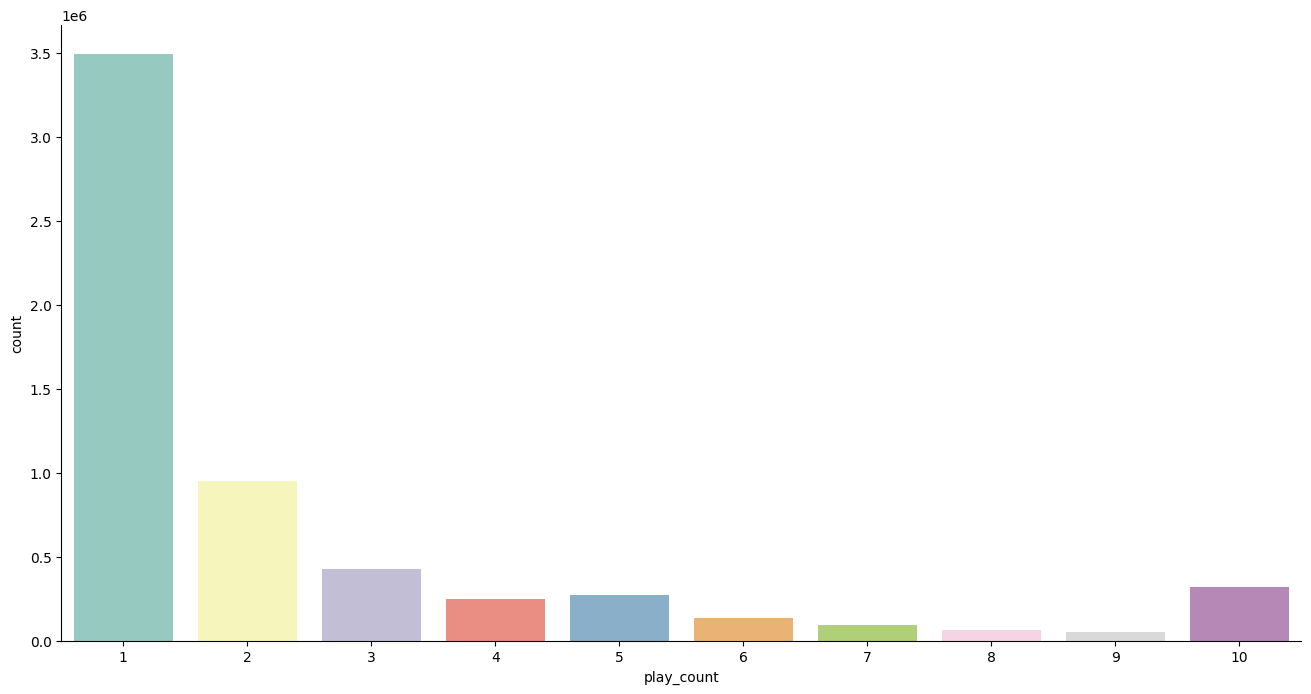

In [23]:
plt.figure(figsize=(16, 8))
sns.barplot(x='play_count', y='count', palette='Set3', data=listen_counts_custom)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [24]:
binning_data2

,user_id,song_id,play_count,title,artist_name,release,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,Thicker Than Water,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,Billy Preston,To Die For,1974
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Flamenco Para Niños,1976
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,12 segundos de oscuridad,Jorge Drexler,10 + Downloaded,2006
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1,Food Chain (Album Version),Eric Hutchinson,Sounds Like This,2008
...,...,...,...,...,...,...,...
10266739,fd7fba879e036460b1c7cf18ae84ffb70d2166f4,SOSZJFV12AB01878CB,9,Teach Me How To Dougie,California Swag District,Teach Me How To Dougie,0
10266740,fd7fba879e036460b1c7cf18ae84ffb70d2166f4,SOUPCXQ12A81C222D9,3,Cookie Jar [feat. The-Dream] (Explicit Album V...,Gym Class Heroes,Cookie Jar [Feat. The-Dream],0
10266741,fd7fba879e036460b1c7cf18ae84ffb70d2166f4,SOUVTSM12AC468F6A7,2,Drop The World,Lil Wayne / Eminem,Drop The World,0
10266743,fd7fba879e036460b1c7cf18ae84ffb70d2166f4,SOWCKVR12A8C142411,1,Use Somebody,Kings Of Leon,Use Somebody,2008


In [25]:
binning_data2[['user_id', 'song_id', 'play_count']].to_csv("train-test-data.csv")

In [4]:
# binning_data2 = pd.read_csv("train-test-data.csv")

In [5]:
# Prepare data for Surprise
from surprise import Dataset, Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(binning_data2[['user_id', 'song_id', 'play_count']], reader)

In [6]:
trainset, testset = train_test_split(data, test_size=.25)

In [7]:
len(testset)

1511858

In [8]:
# Convert testset (a list of tuples) to a DataFrame
# The testset contains (user_id, item_id, actual_rating) tuples
testset_df = pd.DataFrame(testset, columns=['user_id', 'item_id', 'actual_rating'])

In [ ]:
# Save the testset DataFrame to a CSV file
testset_df.to_csv('testset.csv', index=False)

# Model Training

### Model 1:

In [31]:

# Initialize the SVD algorithm
algo = SVD(n_factors=100, n_epochs=50, lr_all=0.01, reg_all=0.1)
# Record the start time
start_time = time.time()
# Train the model
algo.fit(trainset)

# Record the total completion time
training_time = time.time() - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


Total Training Time: 147.78 seconds


### Model 2:

In [34]:

# Initialize the SVD algorithm
algo2 = SVD(n_factors=150, n_epochs=100, lr_all=0.005, reg_all=0.1)
# Record the start time
start_time = time.time()
# Train the model
algo2.fit(trainset)

# Record the total completion time
training_time2 = time.time() - start_time
print(f"Total Training Time: {training_time2:.2f} seconds")

Total Training Time: 367.42 seconds


### Model 3:

In [11]:

# Initialize the SVD algorithm
algo3 = SVD(n_factors=100, n_epochs=50, lr_all=0.01, reg_all=0.5)
# Record the start time
start_time = time.time()
# Train the model
algo3.fit(trainset)

# Record the total completion time
training_time3 = time.time() - start_time
print(f"Total Training Time: {training_time3:.2f} seconds")


Total Training Time: 159.46 seconds


### Test the Model and Report Top 1 and Top 5 Accuracy



In [46]:
def save(predictions,idx):
        
    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'true_r', 'est', 'details'])
    
    # Save to CSV (excluding the 'details' column)
    predictions_df[['user_id', 'item_id', 'true_r', 'est']].to_csv(f'predictions_{idx}.csv', index=False)


In [36]:
predictions  = algo.test(testset)
# print(f"The rmse is {accuracy.rmse(test_predictions, verbose=True)}")

In [37]:
predictions2  = algo2.test(testset)

In [12]:
predictions3  = algo3.test(testset)

In [14]:
def calculate_top_hits(predictions):
    """
    Optimized function to calculate Top-1 and Top-5 hits from prediction results.

    :param predictions: List of prediction tuples from the Surprise model (user_id, item_id, true_r, est, details).
    :return: DataFrame with columns: user_id, top_1_hit, top_5_hit.
    """
    import pandas as pd

    # Convert predictions to a DataFrame
    pred_df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'true_r', 'est', 'details'])

    # Sort by user_id and estimated rating (descending)
    pred_df_sorted = pred_df.sort_values(by=['user_id', 'est'], ascending=[True, False])

    # Group by user_id and collect item_ids into lists
    grouped = pred_df_sorted.groupby('user_id')['item_id'].apply(list).reset_index()

    # Extract top 1 and top 5 items
    grouped['top_1_items'] = grouped['item_id'].apply(lambda x: x[:1])
    grouped['top_5_items'] = grouped['item_id'].apply(lambda x: x[:5])

    # Prepare DataFrame with true items
    true_items = pred_df[['user_id', 'item_id']].drop_duplicates()

    # Merge to align true items with their top recommendations
    merged_df = pd.merge(true_items, grouped[['user_id', 'top_1_items', 'top_5_items']], on='user_id')

    # Calculate hits using vectorized operations
    merged_df['top_1_hit'] = merged_df.apply(lambda row: int(row['item_id'] in row['top_1_items']), axis=1)
    merged_df['top_5_hit'] = merged_df.apply(lambda row: int(row['item_id'] in row['top_5_items']), axis=1)

    # Select relevant columns
    results_df = merged_df[['user_id', 'top_1_hit', 'top_5_hit']]

    return results_df


In [18]:
def graph_result(results_df):
    # Assuming your results DataFrame is already created
    # Calculate the average Top-1 and Top-5 hit rates
    top_1_hit_rate = results_df['top_1_hit'].mean()
    top_5_hit_rate = results_df['top_5_hit'].mean()
    
    # Create a DataFrame to store hit rates for plotting
    hit_rates_df = pd.DataFrame({
        'Hit Rate Type': ['Top-1 Hit Rate', 'Top-5 Hit Rate'],
        'Hit Rate': [top_1_hit_rate, top_5_hit_rate]
    })
    
    # Plotting the hit rates as a bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(hit_rates_df['Hit Rate Type'], hit_rates_df['Hit Rate'], color=['skyblue', 'salmon'])
    
    # Add labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')
    
    # Add titles and labels
    plt.title('Top-1 and Top-5 Hit Rates')
    plt.ylabel('Hit Rate')
    plt.ylim(0, 1)  # Hit rate ranges from 0 to 1
    plt.show()


In [ ]:
result = calculate_top_hits(predictions)

In [ ]:
result2 = calculate_top_hits(predictions2)

In [15]:
result3 = calculate_top_hits(predictions3)

## Result 1: 

In [71]:

top_1_hit_rate = result['top_1_hit'].mean()
top_5_hit_rate = result['top_5_hit'].mean()
print(top_1_hit_rate, top_5_hit_rate)

0.08924316966275933 0.39896604046147194


## Result 2:

In [73]:

top_1_hit_rate = result2['top_1_hit'].mean()
top_5_hit_rate = result2['top_5_hit'].mean()
print(top_1_hit_rate, top_5_hit_rate)

0.0892180350270991 0.3989461973280559


## Result 3:

In [16]:

top_1_hit_rate = result3['top_1_hit'].mean()
top_5_hit_rate = result3['top_5_hit'].mean()
print(top_1_hit_rate, top_5_hit_rate)

0.08948849972745637 0.3997707427081218


## Result Graphs

In [24]:
import pandas as pd

# Define the updated data
data = {
    'Setting': [
        'n_factor=100, epoch=50, lr=0.01, reg=0.1',
        'n_factor=150, epoch=100, lr=0.005, reg=0.1',
        'n_factor=100, epoch=50, lr=0.01, reg=0.5'
    ],
    'Top_1_Hit_Rate': [0.08924316966275933, 0.0892180350270991, 0.08948849972745637],
    'Top_5_Hit_Rate': [0.39896604046147194, 0.3989461973280559, 0.3997707427081218],
    'Training_Time': [147.78, 367.42, 160.46]
}

# Convert to DataFrame
df = pd.DataFrame(data)


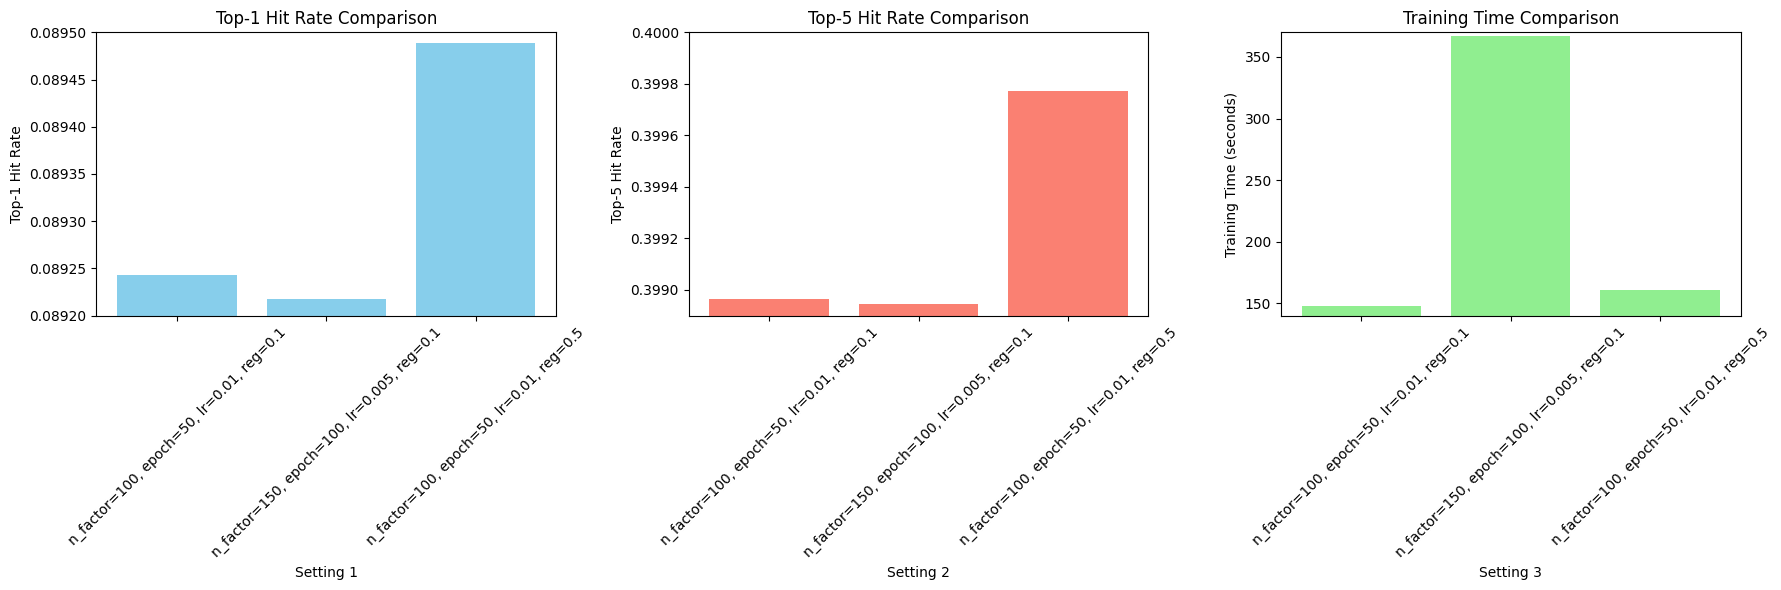

In [23]:

# Set up the figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Bar chart for Top-1 Hit Rate
ax[0].bar(df['Setting'], df['Top_1_Hit_Rate'], color='skyblue')
ax[0].set_title('Top-1 Hit Rate Comparison')
ax[0].set_xlabel('Setting 1')
ax[0].set_ylabel('Top-1 Hit Rate')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylim(0.0892, 0.0895)  # Set the y-axis range to focus on differences

# Bar chart for Top-5 Hit Rate
ax[1].bar(df['Setting'], df['Top_5_Hit_Rate'], color='salmon')
ax[1].set_title('Top-5 Hit Rate Comparison')
ax[1].set_xlabel('Setting 2')
ax[1].set_ylabel('Top-5 Hit Rate')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylim(0.3989, 0.400)  # Set the y-axis range to focus on differences

# Bar chart for Training Time
ax[2].bar(df['Setting'], df['Training_Time'], color='lightgreen')
ax[2].set_title('Training Time Comparison')
ax[2].set_xlabel('Setting 3')
ax[2].set_ylabel('Training Time (seconds)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_ylim(140, 370)  # Set the y-axis range to better show differences

# Adjust layout for better display
plt.tight_layout()
plt.show()

# Result Report

### Dataset Description
I utilized the first 10,000,000 pieces of data from the raw file(train_triplets.txt) as a raw dataset, which is around 1/4 size of the origional dataset. Then, I keep only users who listened to over 20 songs, and only keep songs with more than 200 listener(these decisions are made along the way when I was observing the data, detailed thought process shown above in 'Data Preprocessing' section). 

After the filter, the dataset contains 6,047,430 data. The filtered data has a minimum listening count of 1 and a maximum of 2213(this is max number of times 1 person listen to 1 song), and based on the percentile data, I noticed that 90% of data is within range of 1-6. Therefore, in order to convert the listening count to rating, I binned them into 10 bins with ranges of [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214], this makes sure all count that are > 0, <= 1 becomes rating 1, all counts that are >1, <=2 becomes rating 2....all counts >9, <= 2214 becomes rating 10. As shown in the graph below, this conversion technique shows a reasonable distribution of rating.

                                                            Listening Count Stats
                                        __________________________________________________________
                                                            Maximum Listening Count: 2213
                                                            Minimum Listening Count: 1
                                                            Mean Listening Count: 2.93
                                                            25th Percentile: 1.0
                                                            50th Percentile: 1.0
                                                            75th Percentile: 3.0
                                                            90th Percentile: 6.0


                                                    Bar Graph of Rating Distribution After Binning
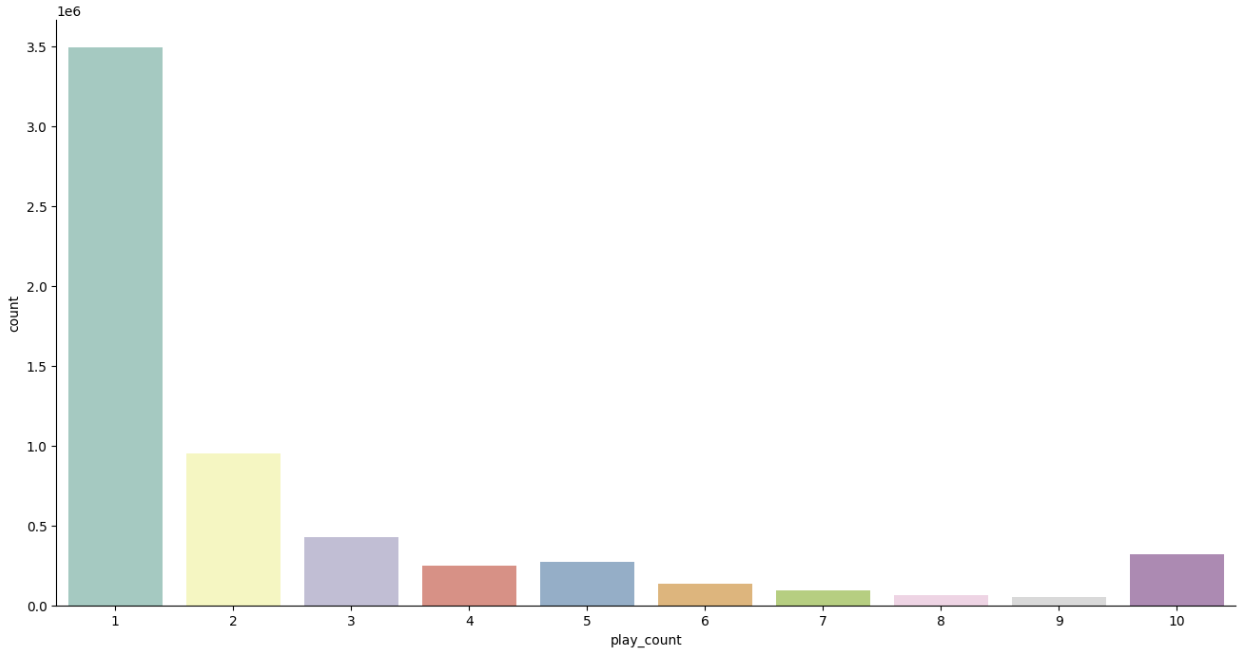

### Train Setting and Result Analysis
I split the filtered data set to a 0.25 train-test split, which means the test set contains in total of 1,511,857 pieces of data. I stored all test data into testset.csv. Then, I ran 3 hyperparameter setting to test the moddel's effectiveness and try to tune it to its best possible hit rate.

For the first model, I use the initial hyperparameter setting is shown below. 

    n_factors = 100
    n_epochs = 50
    lr_all = 0.01
    reg_all = 0.1

The first setting's result has a top 1 hit rate of 0.08924316966275933 and a top 5 hit of 0.39896604046147194. To interpret both hit rate: A top 1 hit rate of 0.08924316966275933 means that about 9% of the time, the system correctly predicted the exact song the user listens to the most in the ranked list of all songs he listens to. A top 5 hit rate of 0.39896604046147194 means that about 40% of the time, the system correctly predicted the song the user listens to as one of the top 5 song he listens to the most.

I believe both scores are not high enough for the system to be put into real world use. This result is within my expectation, because due to the computational resource limitation, I'm training on 1/4 size of the origional full dataset, which means the model might not have enough information to learn to make its best possible prediction. Another thing to note is that the top 1 hit rate is significantly lower than top 5 hit rate. This is also reasonable, since it is inherently more challenging for the model to predict the exact song a user will like compared to predicting top five songs and having 1 matching song.

After analyzing the first result, I aimed to improve the model's performance. I identified several potential reasons for the low hit rate:

n_factor (Latent Factors):
The small number of latent factors (n_factor) may limit the model's ability to learn complex relationships between users and items. Increasing the number of latent factors would allow the model to learn more precise relation ship betweeen users and musics in a higher-dimensional feature space.

Number of Epochs:
The low number of epochs might have caused the model to stop training before converging to the optimal solution. By increasing the number of epochs, the model will have more time to adjust the latent factors and potentially achieve better performance.

Learning Rate:
The learning rate may have been too high, causing the model to make large updates to the parameters and miss the global optimum during training. A smaller learning rate allows the model to make more gradual updates, which will improve the chances of finding the optimal set of parameters.

Therefore, I increased the n factor and num epochs, and decrease the learning rate, as shown below:

    n_factors = 150
    n_epochs = 100
    lr_all = 0.005
    reg_all = 0.1
    
The second model's result has a top 1 hit of 0.0892180350270991, top 5 hit of 0.3989461973280559, which are both worse than the first setting.  What's worth noticing is that the training time increases significanly by more than 50% compare to the first setting. This is expected, because with more number of epochs and more complex setting, more time is needed for the model to finish computing all epochs. The slight decrease in result shows that the model is potentially overfitting. Therefore, for the third model, I increased the regulation factor to reduce overfitting, rest of the setting is identical to model 1.

    n_factors = 100
    n_epochs = 50
    lr_all = 0.01
    reg_all = 0.5

The third model's scores are top 1 hit: 0.08948849972745637, and top 5 hit: 0.3997707427081218, which show a improvement over the first model. This confirms my hypothesis of the model overfitting during the first and second hyperparameter setting.

                                                    Result Table
                                                         |    top 1 hit rate  |    top 5 hit rate   |   Training Time
    _________________________________________________________________________________________________________________________
    n_factor = 100, epoch = 50, lr = 0.01, reg = 0.1     |0.08924316966275933 | 0.39896604046147194 |  147.78
    _________________________________________________________________________________________________________________________
    n_factor = 150, epoch = 100, lr = 0.005, reg = 0.1   |0.0892180350270991  | 0.3989461973280559 |  367.42
    _________________________________________________________________________________________________________________________
    n_factor = 100, epoch = 50, lr = 0.01, reg = 0.5     |0.08948849972745637 | 0.3997707427081218 |  160.46

                                                    Result Graph
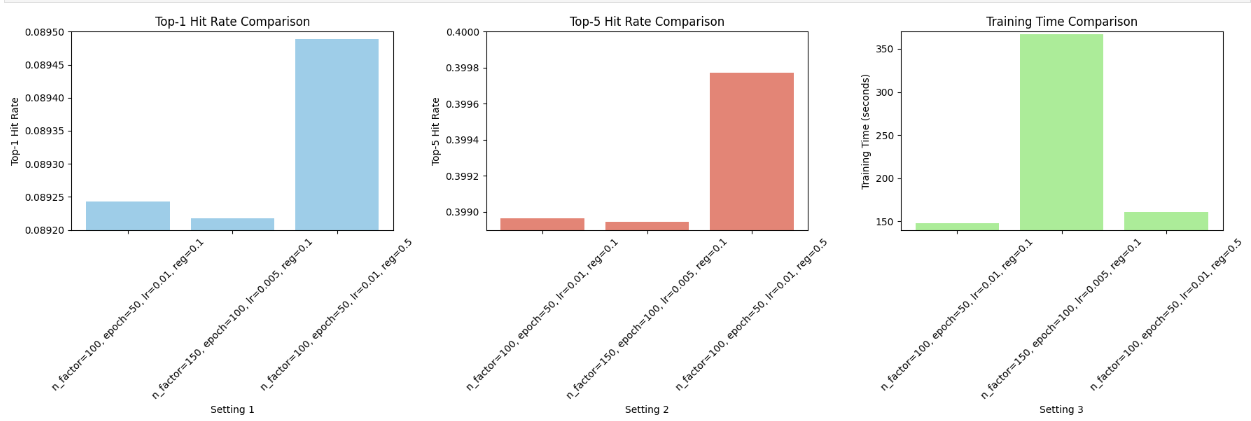

Lastly, What's worth mentioning is that, even though changes in hyperparameters such as n_factor, number of epochs, and learning rate led to some observable differences in the results, the improvements were too small to make significant impact on the model's overall performance. This suggests that either the current dataset size is too small or the model architecture itself may not be sufficient to capture the full complexity of relationship between users and songs. It is also possible that further tuning or other advanced techniques (e.g., cross-validation, different feature engineering) are needed to make meaningful improvements. 


### Reference

I referenced this github repo for my implementation: https://github.com/TejalBalyan/Music_Recommender 